In [1]:
import tensorflow as tf
# List all physical GPU devices
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        # Enable memory growth for the first GPU
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for:", physical_devices[0])
    except RuntimeError as e:
        # Memory growth must be set before initializing GPUs
        print("Error setting memory growth:", e)
else:
    print("No GPU devices found.")

with tf.device('/cpu:0'):
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    from sklearn.svm import SVC
    from tensorflow.python.client import device_lib
    import cv2
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import classification_report, accuracy_score
    from tensorflow.keras import layers, models
    from sklearn.preprocessing import LabelEncoder,StandardScaler
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
    import h5py
    import gc

    gc.enable

    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())

Memory growth enabled for: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13914097943501629454
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4158652416
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13645410534599688889
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
#import tensorflow as tf
#
## Set mixed precision policy
#from tensorflow.keras.mixed_precision import set_global_policy
#
#set_global_policy('mixed_float16')
#
## Check if the policy is set
#print("Mixed precision policy:", tf.keras.mixed_precision.global_policy())

In [3]:
with tf.device('/cpu:0'):
    # Load the numpy array X from the compressed .npz file
    #X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_augemented_train.npz')
    X_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_train_5.npz')
    X_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_test_5.npz')
    X_val   = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\X_val.npz')
    #Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_augemented_train.npz')
    Y_train = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_train_5.npz')
    Y_test  = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_test_5.npz')
    Y_val   = np.load(r'C:\Users\princ\Downloads\Vision datasets\workspace\Y_val.npz')
    
    
    X_train =X_train['X']
    X_test  =X_test ['X']
    X_val   =X_val  ['X']
    Y_train =Y_train['X']
    Y_test  =Y_test ['X']
    Y_val = Y_val ['X']

    # One-hot encode the labels
    label_encoder = LabelEncoder()
    y_train_encoded = to_categorical(label_encoder.fit_transform(Y_train))
    y_test_encoded = to_categorical(label_encoder.transform(Y_test))
    y_val_encoded = to_categorical(label_encoder.transform(Y_val))

    X_train = tf.convert_to_tensor(X_train, np.float32)
    X_test = tf.convert_to_tensor(X_test, np.float32)
    X_val = tf.convert_to_tensor(X_val, np.float32)

    
    y_train_encoded = tf.convert_to_tensor(y_train_encoded, np.float32)
    y_test_encoded = tf.convert_to_tensor(y_test_encoded, np.float32)
    y_val_encoded = tf.convert_to_tensor(y_val_encoded, np.float32)

    image_input_shape=(X_train[0].shape)
    num_classes=y_train_encoded.shape[1]


    print(image_input_shape, num_classes)

(64, 64, 3) 50


In [4]:
# Define the encoder
def build_encoder(input_shape):
    encoder = models.Sequential(name="enhanced_encoder")
    encoder.add(layers.Flatten(input_shape=input_shape))  # Flatten input for a perceptron model
        
        
    encoder.add(layers.Dense(1024, activation='linear',kernel_initializer='he_normal'))   # Fully connected layer
    encoder.add(layers.BatchNormalization())

    encoder.add(layers.Dense(512, activation='linear',name = "last",kernel_initializer='he_normal'))    # Fully connected layer
    return encoder  


model1 = build_encoder(image_input_shape)
model1.summary()
#Get the output of the last layer
last_layer = model1.get_layer(name="last")
latent_dim_encoder = last_layer.output_shape
latent_dim_encoder = latent_dim_encoder[1:]
print(latent_dim_encoder)

Model: "enhanced_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12288)             0         
                                                                 
 dense (Dense)               (None, 1024)              12583936  
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 last (Dense)                (None, 512)               524800    
                                                                 
Total params: 13,112,832
Trainable params: 13,110,784
Non-trainable params: 2,048
_________________________________________________________________
(512,)


In [5]:
# SVM def
def SVM(X_train, y_train, X_test, y_test):
    # Step 4: Train SVC with RBF kernel
    svm = SVC(kernel='rbf', C=10)  # RBF kernel with hyperparameters
    svm.fit(X_train, y_train)  # Train the model

    # Step 5: Evaluate Model
    y_pred = svm.predict(X_test)  # Make predictions

    # Print accuracy and classification report
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    return svm, y_pred

In [6]:
def train_svm_with_encoder(X_train, y_train, X_test, y_test, input_shape):
    # Build and train encoder
    encoder = build_encoder(input_shape)
    encoder.load_weights(r'C:\Users\princ\Downloads\Vision datasets\temp\encoder_weights_new.h5', by_name=True)
    
    # Extract features using the encoder
    X_train_features = encoder.predict(X_train)  # Extract features from X_train
    X_train_features = X_train_features.reshape(X_train.shape[0], -1)  # Flatten features

    X_test_features = encoder.predict(X_test)  # Extract features from X_test
    X_test_features = X_test_features.reshape(X_test.shape[0], -1)  # Flatten features

    # Ensure labels are 1D arrays (decode from one-hot encoding if needed)
    y_train = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
    y_test = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

    # Train and evaluate the SVM
    best_svm, y_pred = SVM(X_train_features, y_train, X_test_features, y_test)

    # Calculate accuracy manually (equivalent to the original approach)
    accuracy = np.mean(y_pred == y_test)  # Compare predicted vs true labels
    print(f"Prediction Accuracy: {accuracy * 100:.2f}%")

    return  best_svm, y_pred


In [7]:
svm, y_pred = train_svm_with_encoder(X_train, Y_train, X_test, Y_test, image_input_shape)

24/24 [==============================] - 0s 2ms/step
Accuracy: 0.44591029023746703
              precision    recall  f1-score   support

           0       0.73      0.35      0.47        23
           1       0.32      0.44      0.37        16
           2       0.59      0.68      0.63        19
           3       0.12      0.10      0.11        10
           4       0.54      0.65      0.59        20
           5       0.53      0.50      0.51        18
           6       0.63      0.75      0.69        16
           7       0.50      0.53      0.51        17
           8       0.38      0.31      0.34        16
           9       0.38      0.25      0.30        12
          10       0.22      0.22      0.22        18
          11       0.50      0.40      0.44        15
          12       0.55      0.61      0.58        18
          13       0.27      0.36      0.31        11
          14       0.30      0.33      0.32        18
          15       0.40      0.29      0.33        1

In [8]:

def visualize_results(y_test, y_predict):
    # y_predict: Predictions from SVM (already class labels)
    # y_test: True labels (should be class labels, not one-hot encoded)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Plot confusion matrix with a wider figure
    plt.figure(figsize=(23, 23))  # Wider graph: 12 units wide, 6 units high
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(len(np.unique(y_test))), yticklabels=np.arange(len(np.unique(y_test))))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def class_wise_accuracy(y_test, y_predict):
    # y_predict: Predictions from SVM (class labels)
    # y_test: True labels (class labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_predict)

    # Calculate class-wise accuracy
    class_accuracies = cm.diagonal() / cm.sum(axis=1)  # Diagonal elements (correct predictions) / Row sums (total class instances)

    # Print class-wise accuracy
    print("Class-wise accuracy:")
    for i, accuracy in enumerate(class_accuracies):
        print(f"Class {i}: {accuracy * 100:.2f}%")

    # Plot class-wise accuracy as a bar chart with a wider figure
    plt.figure(figsize=(20, 6))  # Wider graph: 12 units wide, 6 units high
    plt.bar(range(len(class_accuracies)), class_accuracies * 100, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Class-wise Accuracy')
    plt.xticks(range(len(class_accuracies)))
    plt.ylim(0, 100)
    plt.show()

    return class_accuracies

def show_images_from_class(X, y, class_label, num_images=5):
    """
    Display a given number of images from a specified class, arranged with 5 images per row.
    
    Parameters:
    - X: The image data (features) as a numpy array or pandas dataframe.
    - y: The labels corresponding to the images (class labels).
    - class_label: The class label for which to show the images.
    - num_images: Number of images to display (default is 5).
    """
    # Find the indices of the images that belong to the given class
    class_indices = np.where(y == class_label)[0]
    
    # Randomly select 'num_images' indices from the class
    selected_indices = np.random.choice(class_indices, num_images, replace=False)
    
    # Calculate the number of rows needed to display the images in 5 per row
    num_rows = (num_images // 5) + (num_images % 5 != 0)
    
    # Set up the plot
    plt.figure(figsize=(15, 3 * num_rows))
    
    for i, idx in enumerate(selected_indices):
        plt.subplot(num_rows, 5, i+1)  # Rows x 5 columns
        plt.imshow(X[idx], cmap='gray')  # Assuming grayscale images, adjust if RGB
        plt.title(f"Class {class_label}")
        plt.axis('off')  # Hide axes
    
    plt.show()

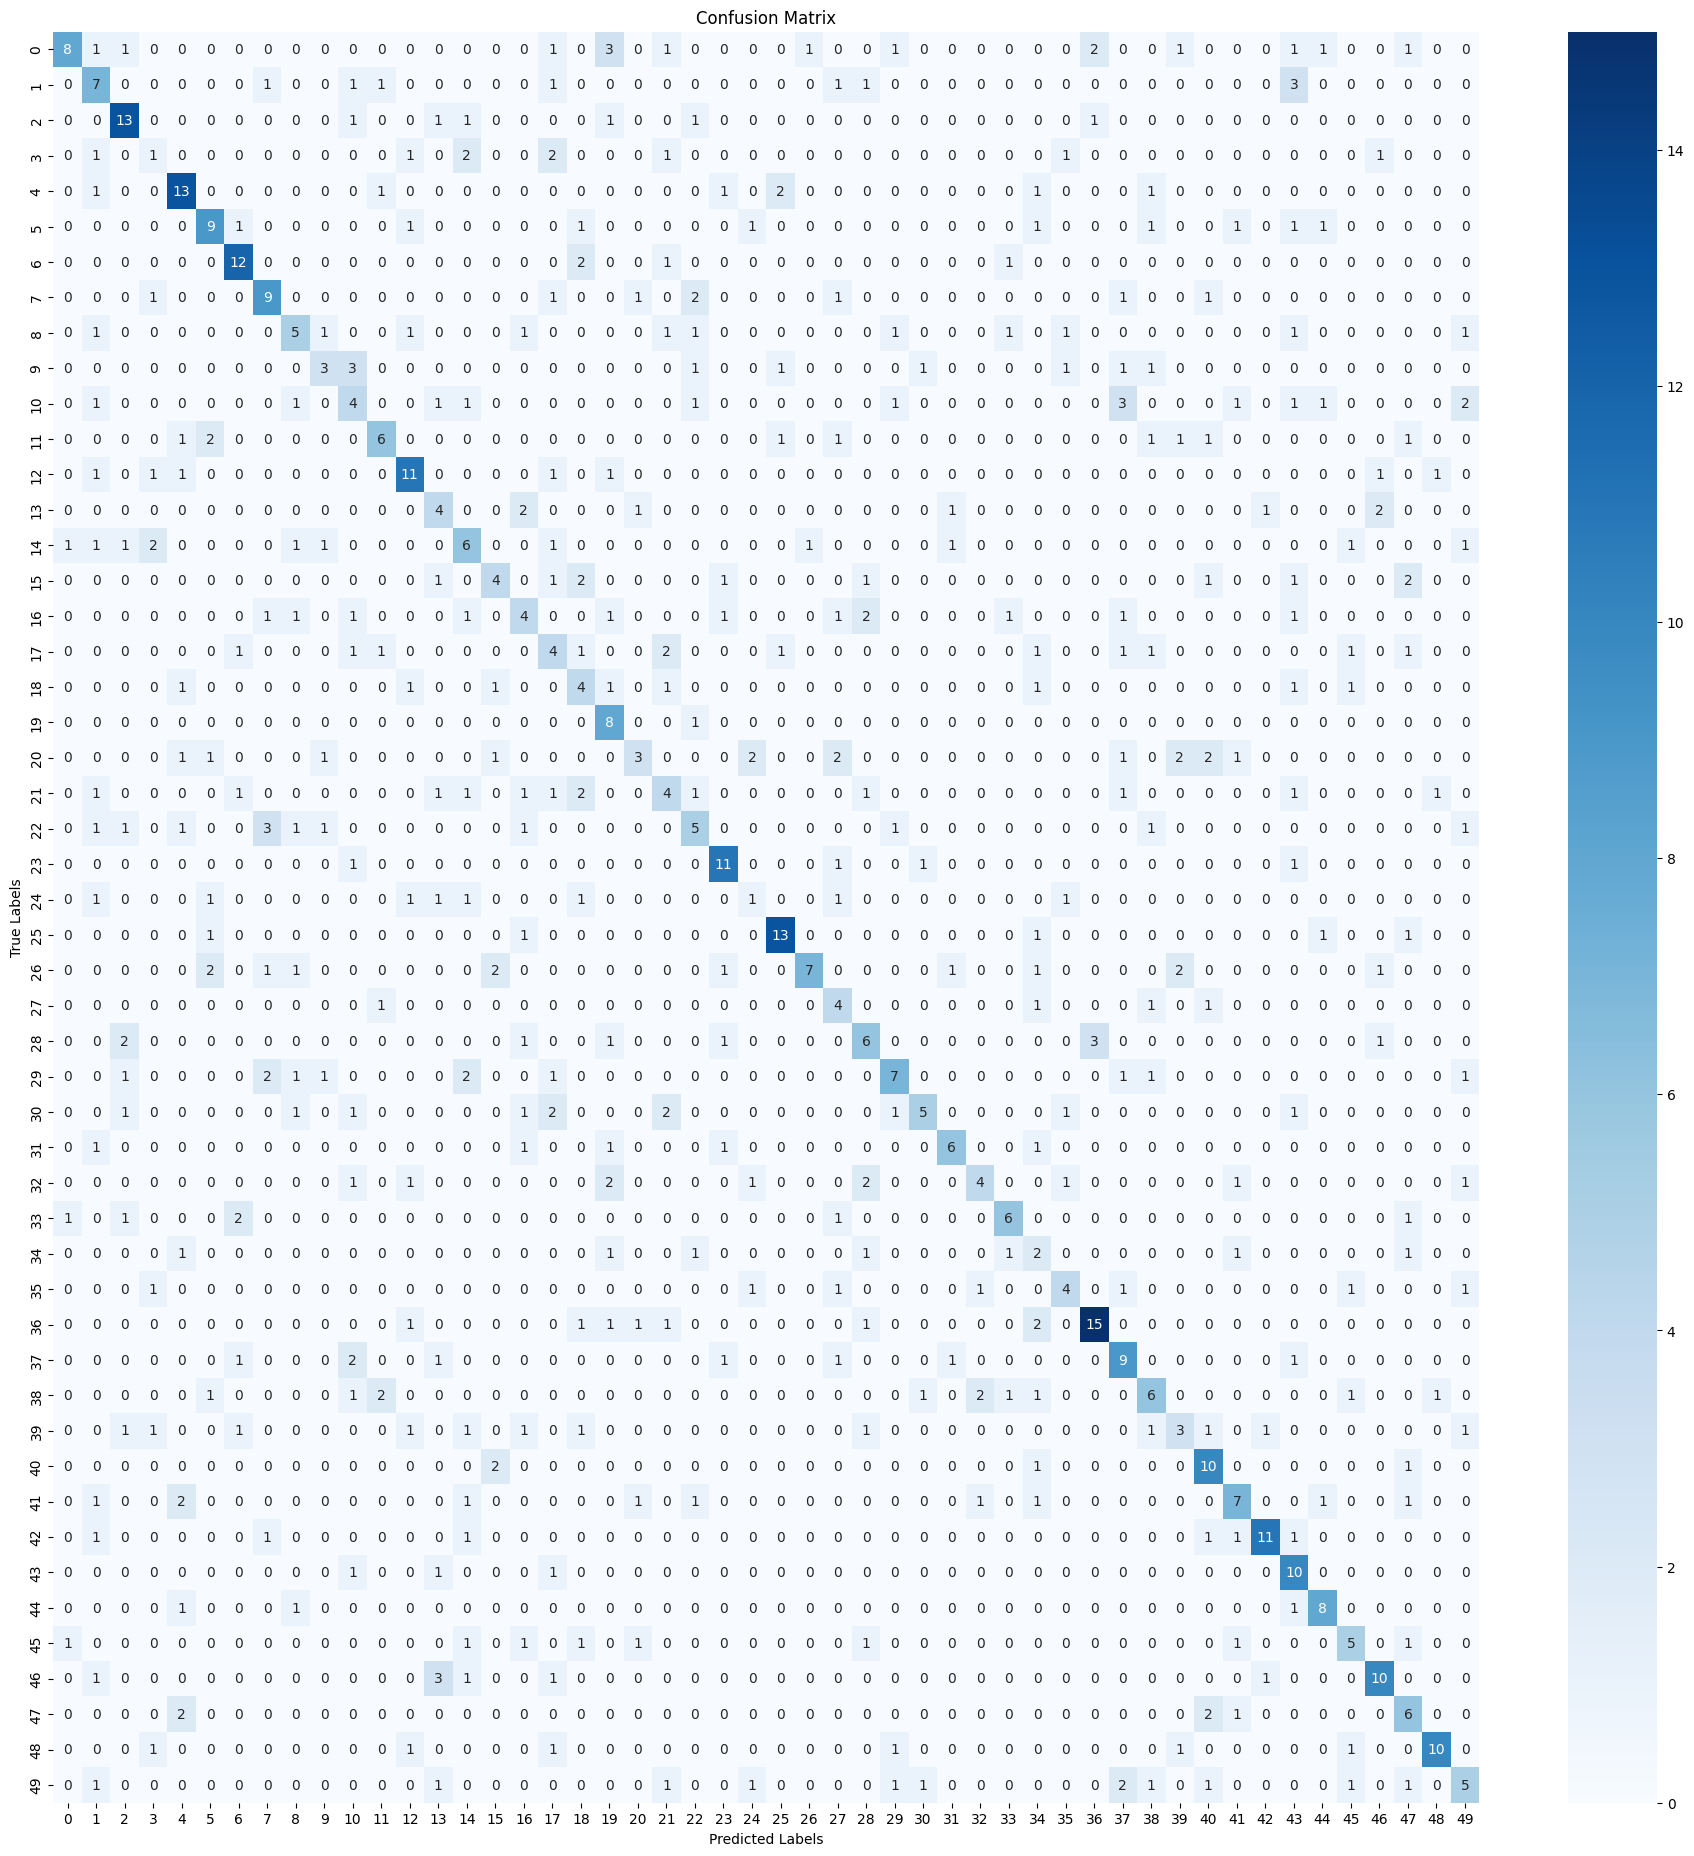

Class-wise accuracy:
Class 0: 34.78%
Class 1: 43.75%
Class 2: 68.42%
Class 3: 10.00%
Class 4: 65.00%
Class 5: 50.00%
Class 6: 75.00%
Class 7: 52.94%
Class 8: 31.25%
Class 9: 25.00%
Class 10: 22.22%
Class 11: 40.00%
Class 12: 61.11%
Class 13: 36.36%
Class 14: 33.33%
Class 15: 28.57%
Class 16: 25.00%
Class 17: 25.00%
Class 18: 33.33%
Class 19: 88.89%
Class 20: 17.65%
Class 21: 23.53%
Class 22: 29.41%
Class 23: 73.33%
Class 24: 11.11%
Class 25: 72.22%
Class 26: 36.84%
Class 27: 50.00%
Class 28: 40.00%
Class 29: 38.89%
Class 30: 31.25%
Class 31: 54.55%
Class 32: 28.57%
Class 33: 50.00%
Class 34: 22.22%
Class 35: 36.36%
Class 36: 65.22%
Class 37: 52.94%
Class 38: 35.29%
Class 39: 20.00%
Class 40: 71.43%
Class 41: 41.18%
Class 42: 64.71%
Class 43: 76.92%
Class 44: 72.73%
Class 45: 38.46%
Class 46: 58.82%
Class 47: 54.55%
Class 48: 62.50%
Class 49: 29.41%


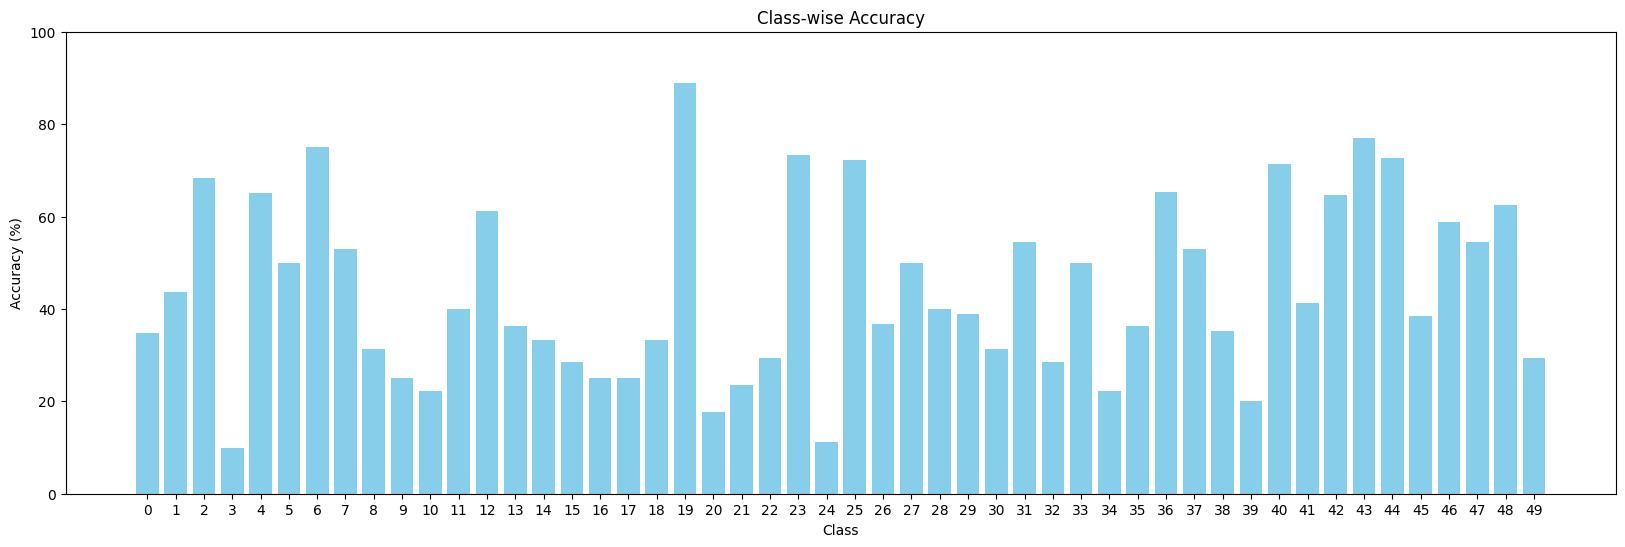

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

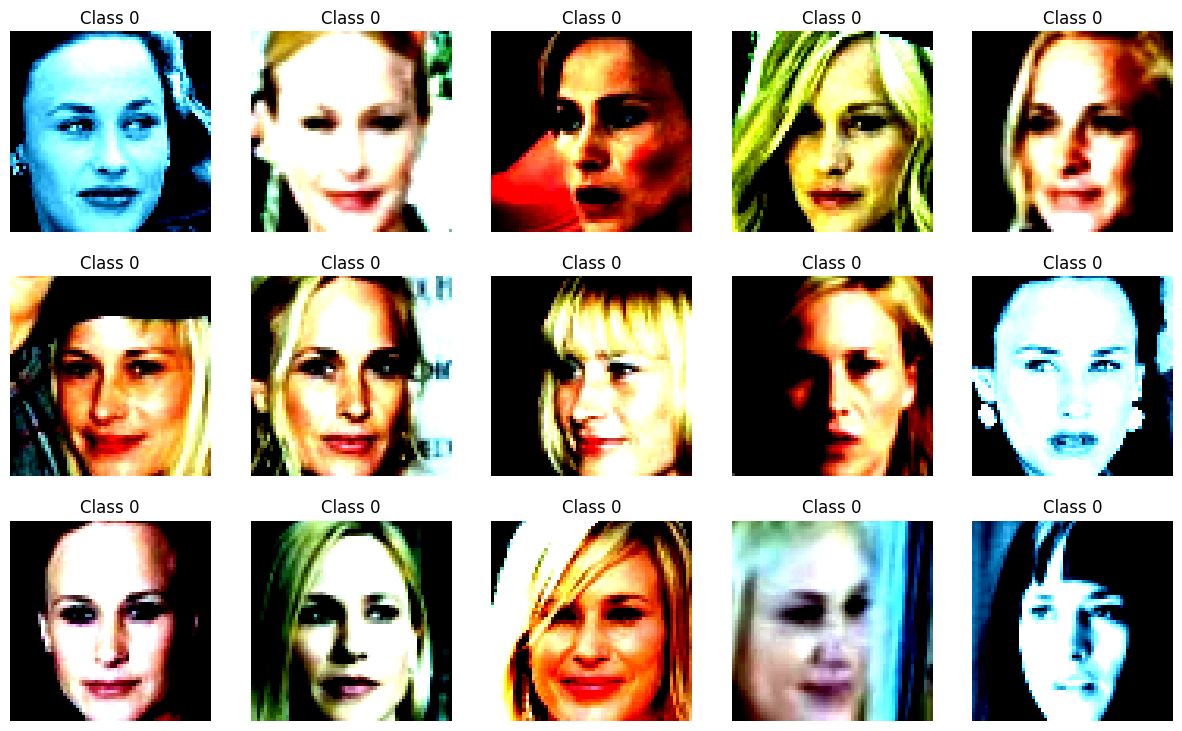

In [9]:
# Visualize confusion matrix
visualize_results(Y_test, y_pred)

# Calculate class-wise accuracy
class_wise_accuracy(Y_test, y_pred)

# Show images for a specific class (e.g., class 0)
show_images_from_class(X_test, Y_test, class_label=0, num_images=15)